In [1]:
import os
import numpy as np
import argparse

import pandas as pd
from sklearn.decomposition import PCA
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import umap.umap_ as umap
import time

import torch
from spiral_pyg.main import SPIRAL_integration_pyG
from spiral_pyg.pyG_layers import *
from spiral_pyg.utils import *
os.environ['R_HOME']='/home/tguo/tguo2/miniconda3/envs/pyg/lib/R'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
# ############seed#############
seed=1234
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

In [3]:
dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
sample_name=[151507,151508,151509,151510,151669,151670,151671,151672,151673,151674,151675,151676]
samples=sample_name[0:12]
SEP=','
net_cate='_KNN_'
knn=6

P_WALK=knn
WALK_LEN=1
N_WALK_LEN=knn
NUM_NEG=knn

feat_file=[]
edge_file=[]
meta_file=[]
coord_file=[]
flags=''
flags1=str(samples[0])
for i in range(1,len(samples)):
    flags1=flags1+'-'+str(samples[i])
for i in range(len(samples)):
    feat_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_features-1.txt")
    edge_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
    meta_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_label-1.txt")
    coord_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_positions-1.txt")
    flags=flags+'_'+str(samples[i])
N=pd.read_csv(feat_file[0],header=0,index_col=0).shape[1]
if (len(samples)==2):
    M=1
else:
    M=len(samples)

In [4]:
parser = argparse.ArgumentParser()

parser.add_argument('--AEdims', type=list, default=[N,[512],32], help='Dim of encoder.')
parser.add_argument('--AEdimsR', type=list, default=[32,[512],N], help='Dim of decoder.')
parser.add_argument('--GSdims', type=list, default=[512,32], help='Dim of GraphSAGE.')
parser.add_argument('--znoise_dim', type=int, default=4, help='Dim of noise embedding.')
parser.add_argument('--CLdims', type=list, default=[4,[],M], help='Dim of classifier.')
parser.add_argument('--DIdims', type=list, default=[28,[32,16],M], help='Dim of discriminator.')
parser.add_argument('--beta', type=float, default=1.0, help='weight of GraphSAGE.')
# parser.add_argument('--beta', type=float, default=0.2, help='weight of GraphSAGE.')
parser.add_argument('--agg_class', type=str, default='mean', help='Function of aggregator.')
parser.add_argument('--num_samples', type=list, default=[knn,knn], help='number of neighbors to sample.')

parser.add_argument('--P_WALK', type=int, default=P_WALK, help='number of walks of random work for postive pairs.')
parser.add_argument('--WALK_LEN', type=int, default=WALK_LEN, help='walk length of random work for postive pairs.')
parser.add_argument('--N_WALK_LEN', type=int, default=N_WALK_LEN, help='number of walks of random work for negative pairs.')
parser.add_argument('--NUM_NEG', type=int, default=NUM_NEG, help='number of negative pairs.')
parser.add_argument('--P', type=float, default=1.0, help=' likelihood of immediately revisiting a node in the walk.')
parser.add_argument('--Q', type=float, default=1.0, help='Control parameter to interpolate between breadth-first strategy and depth-first strategy.')



parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=2048, help='Size of batches to train.')
parser.add_argument('--lr', type=float, default=1e-3, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay.')
parser.add_argument('--alpha1', type=float, default=N, help='Weight of decoder loss.')
parser.add_argument('--alpha2', type=float, default=1, help='Weight of GraphSAGE loss.')
parser.add_argument('--alpha3', type=float, default=1, help='Weight of classifier loss.')
parser.add_argument('--alpha4', type=float, default=1, help='Weight of discriminator loss.')
parser.add_argument('--lamda', type=float, default=1, help='Weight of GRL.')
parser.add_argument('--random_seed', type=float, default=8, help='random seed.')

params,unknown=parser.parse_known_args()

In [ ]:
SPII=SPIRAL_integration_pyG(params,samples,feat_file,edge_file,meta_file)
SPII.train()
SPII.model.eval()
all_embed,ae_out=SPII.model.full_forward(SPII.FEAT[:,:-1], SPII.edge_index,SPII.params.lamda,SPII.de_act,SPII.cl_act)
ae_embed,gs_embed,embed=all_embed
[x_bar,x]=ae_out
embed=embed.cpu().detach()
names=['SPIRAL_'+str(i) for i in np.arange(embed.shape[1])]
embed1=pd.DataFrame(np.array(embed),index=SPII.meta.index,columns=names)
meta=SPII.meta.values
# embed1.to_csv(dirs+"gtt_output/SPIRAL_pyg"+flags+"_embed_"+str(SPII.params.batch_size)+".csv")

--------------------------------
Training.
processed: 51:  51%|█████████████████████▍                    | 51/100 [48:02<45:50, 56.13s/it, AE_loss=0.0536, CLAS_loss=2.46, DISC_loss=2.4, GS_loss=1.04, total_loss=312]

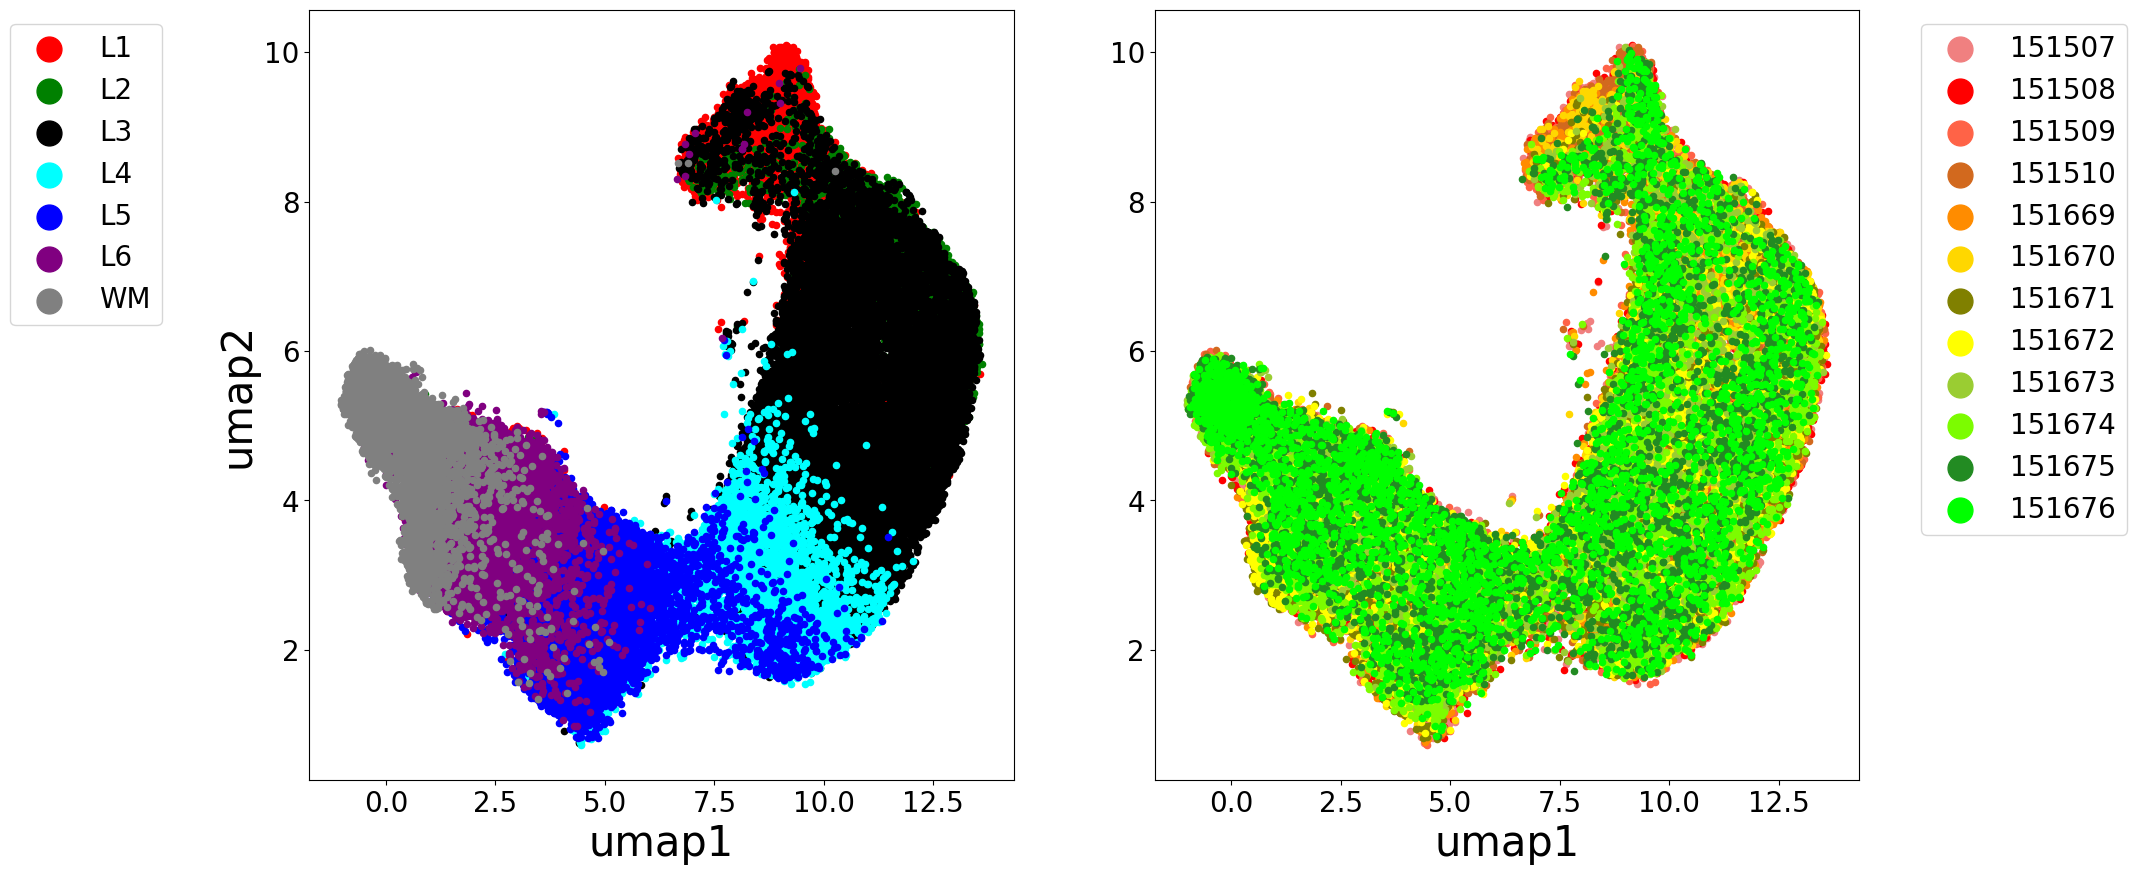

In [8]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
# x=PCA(n_components=30).fit_transform(SPII.feat)
# embed=pd.read_csv(dirs+"gtt_output/AGC_embed"+flags+"_xent.csv",index_col=0,header=0).values
celltype=meta[:,0]
batch=meta[:,1]
ul=np.unique(celltype)
ub=np.unique(batch)
# umap_mat=umap.UMAP().fit_transform(embed1.values[:,4:])
colour2=['r','g','black','cyan','blue','purple','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour2[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour1[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

step2: clustering

In [18]:
# import anndata
# import scanpy as sc
# ann=anndata.AnnData(SPII.feat)
# ann.obsm['spiral']=embed1.iloc[:,SPII.params.znoise_dim:].values
# sc.pp.neighbors(ann,use_rep='spiral')

n_clust=7
# res1=0.6 ####adjust to make sure 7 clusters
# res2=0.6
# sc.tl.leiden(ann,resolution=res1)
# sc.tl.louvain(ann,resolution=res2)
ann = mclust_R(ann, used_obsm='spiral', num_cluster=n_clust)

ann.obs['batch']=SPII.meta.loc[:,'batch'].values
ub=np.unique(ann.obs['batch'])
sc.tl.umap(ann)
coord=pd.read_csv(coord_file[0],header=0,index_col=0)
for i in np.arange(1,len(samples)):
    coord=pd.concat((coord,pd.read_csv(coord_file[i],header=0,index_col=0)))

coord.columns=['y','x']
ann.obsm['spatial']=coord.loc[ann.obs_names,:].values
# # cluster_file=dirs+"gtt_output/SPIRAL"+flags+"_louvain.csv"
# # pd.DataFrame(ann.obs['louvain']).to_csv(cluster_file)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [16]:
print(ann.obs['leiden'])
print(ann.obs['louvain'])

151507-AAACAACGAATAGTTC-1    5
151507-AAACAAGTATCTCCCA-1    0
151507-AAACAATCTACTAGCA-1    5
151507-AAACACCAATAACTGC-1    6
151507-AAACAGCTTTCAGAAG-1    2
                            ..
151676-TTGTTGTGTGTCAAGA-1    2
151676-TTGTTTCACATCCAGG-1    6
151676-TTGTTTCATTAGTCTA-1    6
151676-TTGTTTCCATACAACT-1    2
151676-TTGTTTGTGTAAATTC-1    4
Name: leiden, Length: 47329, dtype: category
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']
151507-AAACAACGAATAGTTC-1    3
151507-AAACAAGTATCTCCCA-1    0
151507-AAACAATCTACTAGCA-1    3
151507-AAACACCAATAACTGC-1    6
151507-AAACAGCTTTCAGAAG-1    1
                            ..
151676-TTGTTGTGTGTCAAGA-1    2
151676-TTGTTTCACATCCAGG-1    6
151676-TTGTTTCATTAGTCTA-1    6
151676-TTGTTTCCATACAACT-1    1
151676-TTGTTTGTGTAAATTC-1    3
Name: louvain, Length: 47329, dtype: category
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']


step3: smooth clusters

In [22]:
from smooting_clustering import refine
from sklearn.metrics.pairwise import euclidean_distances
ann.obs['SPIRAL']=ann.obs['mclust']
ann.obs['SPIRAL_refine']=ann.obs['SPIRAL']
ub=np.unique(ann.obs['batch'])
for i in range(len(ub)):
    idx=np.where(ann.obs['batch']==ub[i])[0]
    ann1=ann[idx,:]
    sample_id=ann1.obs_names
    pred=ann1.obs['SPIRAL']
    dis=euclidean_distances(ann1.obsm['spatial'],ann1.obsm['spatial'])
    refined_pred=refine(sample_id, pred, dis, num_nbs=knn)
    ann.obs['SPIRAL_refine'][idx]=refined_pred
    
# cluster_file_save=dirs+"metrics/spiral"+flags+"_seuratmethod_clust_modify.csv"
# pd.DataFrame(ann.obs['SPIRAL_refine']).to_csv(cluster_file_save)

/home/tguo/tguo2/miniconda3/envs/pyg/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


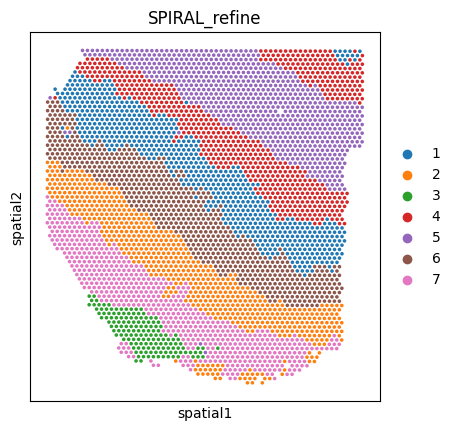

/home/tguo/tguo2/miniconda3/envs/pyg/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


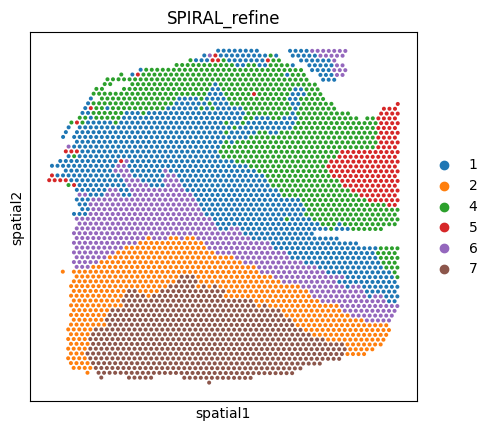

/home/tguo/tguo2/miniconda3/envs/pyg/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


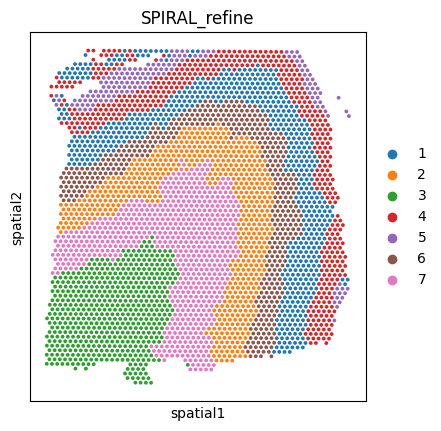

/home/tguo/tguo2/miniconda3/envs/pyg/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


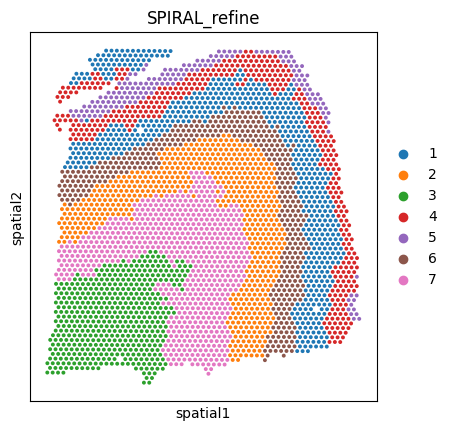

In [23]:
metric='SPIRAL_refine'
ann1=ann[ann.obs['batch']==ub[0],:]
sc.pl.spatial(ann1,color=metric, spot_size=100)
ann1=ann[ann.obs['batch']==ub[4],:]
sc.pl.spatial(ann1,color=metric, spot_size=100)
ann1=ann[ann.obs['batch']==ub[8],:]
sc.pl.spatial(ann1,color=metric, spot_size=100)
ann1=ann[ann.obs['batch']==ub[11],:]
sc.pl.spatial(ann1,color=metric, spot_size=100)